In [1]:
#settings
%load_ext autoreload
%autoreload 2
try:
  import google.colab
  in_colab = True
except:
  in_colab = False
print(in_colab)

False


In [2]:
#installs (for colab only, run this once)
if in_colab:
    ! git clone https://github.com/GreggHeller1/gregg-circ-homer-models.git

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import leastsq, minimize
import lmfit
from pprint import pprint
from collections import OrderedDict
import pandas as pd
import os

In [4]:
if in_colab:
    %cd /content/gregg-circ-homer-models
from src import config as cfg
from src import plotting as plot
from src import computation as comp
from src import helper_functions as hf

In [5]:
#cwd if in colab for file loading to work
if in_colab:
    %cd /content/gregg-circ-homer-models/scripts
    
test_path = os.path.join('demo_data', 'test.txt')
print(test_path)
cwd = os.getcwd()
repo_path = os.path.split(cwd)[0]

print(os.path.exists(test_path))

demo_data\test.txt
False


In [6]:
#testing setup with bicuculin 
#Produce parameter sets to optimize from starting values with some params fixed or pinned
bicuc_targets_dict = {
    'measured_timepoints': np.array([0,2/24, 6/24, 24/24, 48/24]),  #MUST contain 0
    'measured_circ_homer_levels': np.array([1, 1.5, 2, 2.5, 3]),
    'measured_homer1a_levels': np.array([1, 12, 19, 3, 2]),
}
bicuc_targets_df = pd.DataFrame(bicuc_targets_dict)

new_params_dict = OrderedDict()
new_params_dict['transcription_rate']= [1, 12*3, 4*3, 2, 2]
new_params_dict['splice_rate']= [0.5]
new_params_dict['circ_rate']= [.01]
new_params_dict['lin_decay']= [25]
new_params_dict['circ_decay']= [.01]   

param_names_list = new_params_dict.keys()

bounds_dict = hf.get_bounds_dict(-cfg.simulate_t_units_before_t0, cfg.get_max_t(bicuc_targets_df['measured_timepoints']))
        
#establish the null parameters (all there but all 0)
null_bicuc_params = hf.create_new_homer_parameters(bicuc_targets_df['measured_timepoints'], param_names_list)

#now override some params from the base null the default params for each of the models we want to test
#and also set bounds on the fitable parameters
stable_circ_params =  hf.update_params(null_bicuc_params, new_params_dict, bounds_dict)

new_params_dict = {
  'circ_rate': [.01, .01] ,
  'circ_rate_tp': [0, 1.5] ,
  }

circ_up_params = hf.update_params(stable_circ_params, new_params_dict, bounds_dict)

new_params_dict = {
  'circ_decay': ['lin_decay_0'],
  }
matched_decay_params = hf.update_params(stable_circ_params, new_params_dict, bounds_dict)
#bicuc_param_sets['stable_circ_params'].pretty_print()

bicuc_param_sets = OrderedDict()  #Each new set of parameters will be placed in here
bicuc_param_sets['matched_decay_params'] = matched_decay_params
bicuc_param_sets['stable_circ_params'] = stable_circ_params
bicuc_param_sets['circ_up_params']= circ_up_params

Index(['measured_timepoints', 'measured_circ_homer_levels',
       'measured_homer1a_levels'],
      dtype='object')


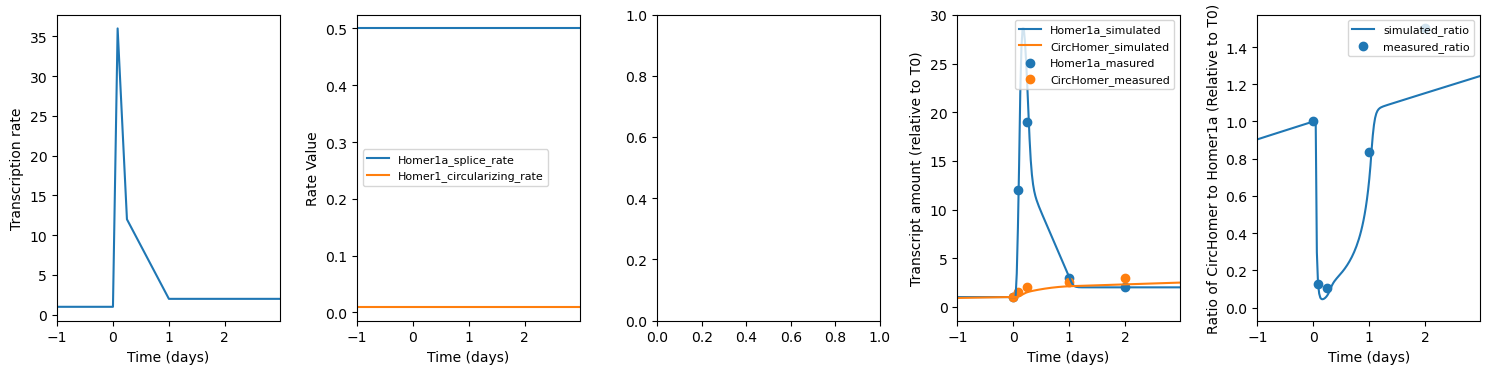

In [7]:
min_t = -cfg.simulate_t_units_before_t0
max_t = cfg.get_max_t(bicuc_targets_df['measured_timepoints'])
print(bicuc_targets_df.columns)
#rerun with the best parameters so we have the full timecourse of the simulation
time_varying_df = comp.simulate(bicuc_param_sets['circ_up_params'], param_names_list, min_t_units=min_t, max_t_units=max_t)

plot.make_timecourse_figures(time_varying_df, bicuc_targets_df)
plt.tight_layout()
plt.show()

(<Figure size 1500x400 with 5 Axes>,
 array([<Axes: xlabel='Time (days)', ylabel='Transcription rate'>,
        <Axes: xlabel='Time (days)', ylabel='Rate Value'>, <Axes: >,
        <Axes: xlabel='Time (days)', ylabel='Transcript amount (relative to T0)'>,
        <Axes: xlabel='Time (days)', ylabel='Ratio of CircHomer to Homer1a (Relative to T0)'>],
       dtype=object),
 0           NaN
 1           NaN
 2      0.002860
 3      0.003836
 4      0.005019
          ...   
 619    1.619253
 620    1.620983
 621    1.622712
 622    1.624441
 623    1.626170
 Length: 624, dtype: float64)

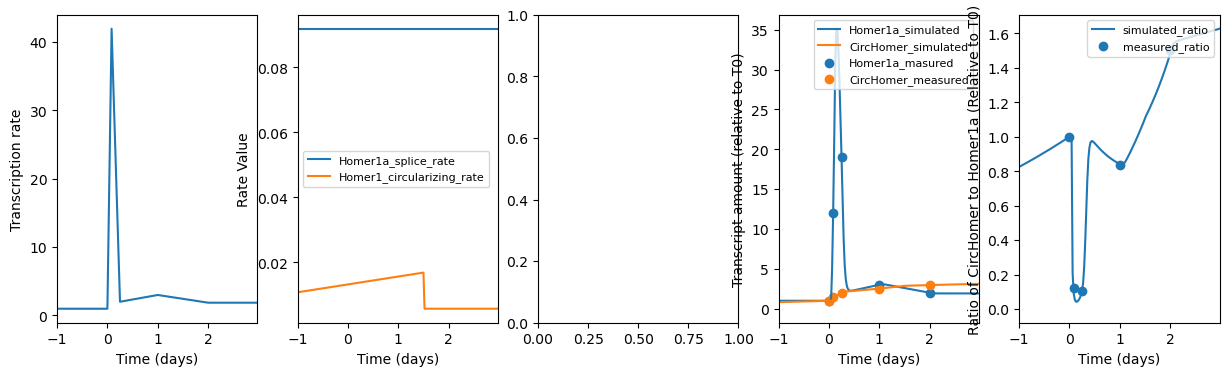

In [8]:
result, time_varying_df = comp.fit_system(bicuc_param_sets['circ_up_params'], param_names_list, bicuc_targets_df)
plot.make_timecourse_figures(time_varying_df, bicuc_targets_df)

In [9]:


def main(param_sets_dict, fit_function, param_names_list, targets_df, experiment_name, repo_path):
    model_names = []
    aics = []
    ratio_timecourses = {}
    for model_name, param_set in param_sets_dict.items():
        
        result, time_varying_df = fit_function(param_set, param_names_list, targets_df)
    
        model_names.append(model_name)
        aics.append(result.aic)

        #plot and save timecourse figures
        fig, axs, ratio_timecourse = plot.make_timecourse_figures(time_varying_df, targets_df, title=f'{experiment_name}_{model_name}')
        ratio_timecourses[model_name] = ratio_timecourse
        save_path = os.path.join(repo_path, 'demo_data', f'{experiment_name}_{model_name}_timecourse_subplots.png')
        fig.savefig(save_path, bbox_inches='tight')

        #decay_df = comp.simulate(parameters, param_names_list, min_t_units=0, max_t_units = 7)
        
    #plot and save AIC scores
    stat_name = 'aic'
    fig, axs = plot.make_stat_bar_chart(model_names, aics, stat_name=stat_name, title=f'{experiment_name}_{stat_name}')
    save_path = os.path.join(repo_path, 'demo_data', f'{experiment_name}_{stat_name}_bar.png')
    fig.savefig(save_path, bbox_inches='tight')

    fig, axs = plot.make_overlapping_ratio_timecourse_plot(targets_df, time_varying_df, ratio_timecourses, title=f'{experiment_name}')
    save_path = os.path.join(repo_path, 'demo_data', f'{experiment_name}_ratios.png')
    fig.savefig(save_path, bbox_inches='tight')




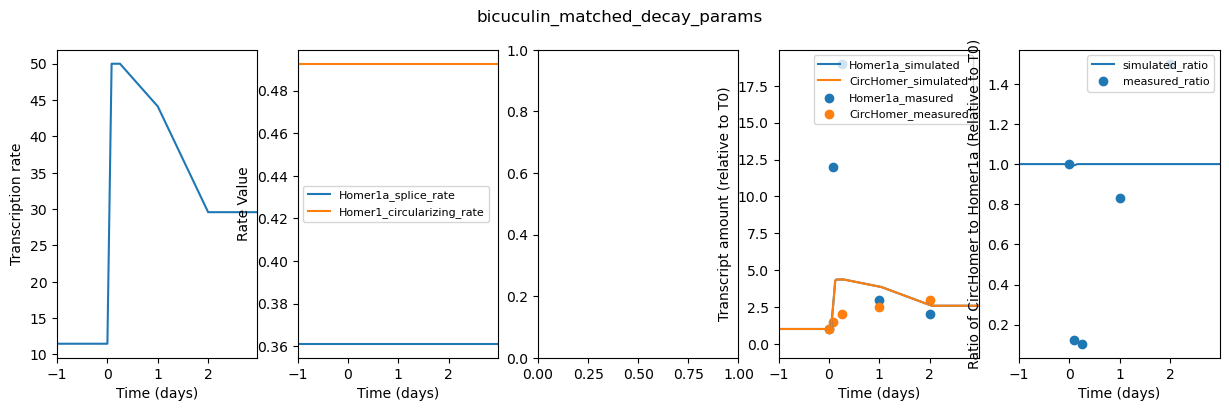

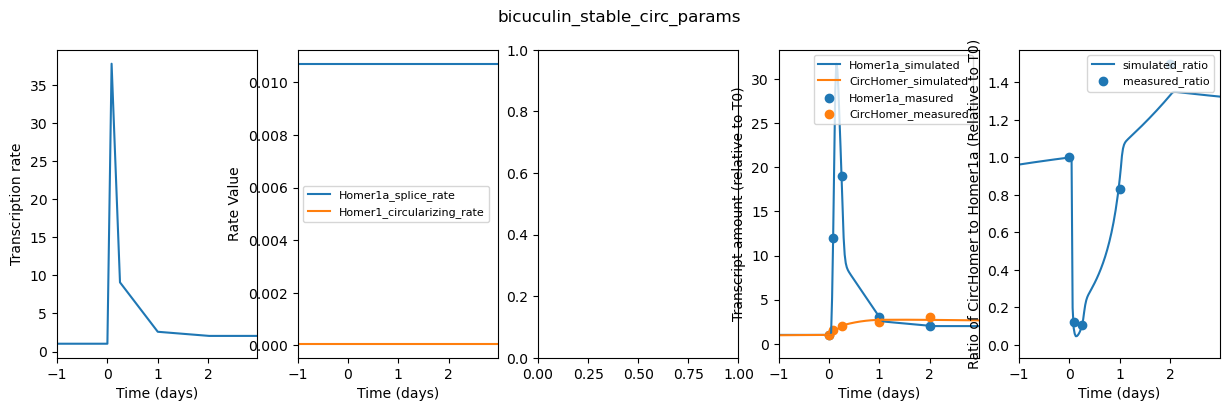

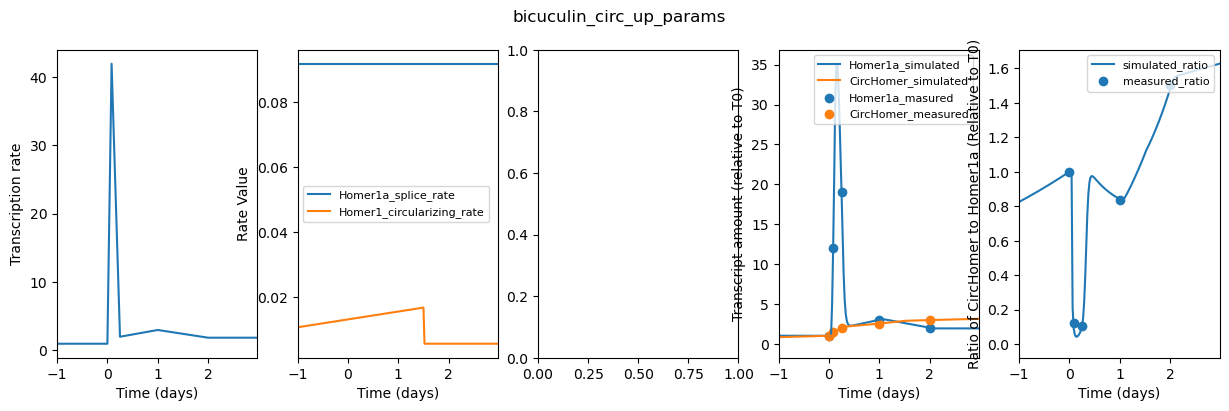

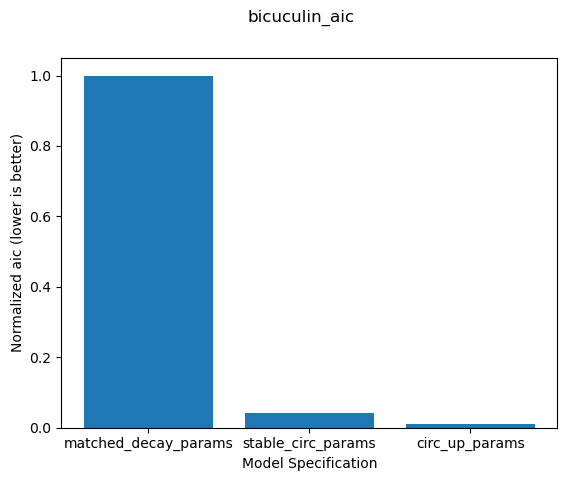

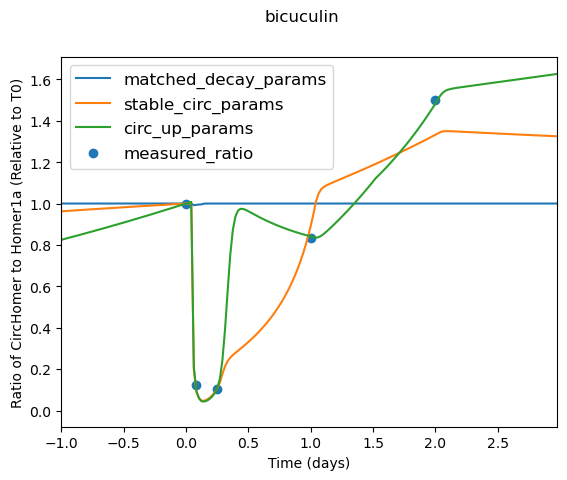

In [10]:
#testing setup with bicuculin 
#Produce parameter sets to optimize from starting values with some params fixed or pinned
bicuc_targets_dict = {
    'measured_timepoints': np.array([0,2/24, 6/24, 24/24, 48/24]),  #MUST contain 0
    'measured_circ_homer_levels': np.array([1, 1.5, 2, 2.5, 3]),
    'measured_homer1a_levels': np.array([1, 12, 19, 3, 2]),
}
bicuc_targets_df = pd.DataFrame(bicuc_targets_dict)

new_params_dict = OrderedDict()
new_params_dict['transcription_rate']= [1, 12*3, 4*3, 2, 2]
new_params_dict['splice_rate']= [0.5]
new_params_dict['circ_rate']= [.01]
new_params_dict['lin_decay']= [25]
new_params_dict['circ_decay']= [.01]   

param_names_list = new_params_dict.keys()

bounds_dict = hf.get_bounds_dict(-cfg.simulate_t_units_before_t0, cfg.get_max_t(bicuc_targets_df['measured_timepoints']))
        
#establish the null parameters (all there but all 0)
null_bicuc_params = hf.create_new_homer_parameters(bicuc_targets_df['measured_timepoints'], param_names_list)

#now override some params from the base null the default params for each of the models we want to test
#and also set bounds on the fitable parameters
stable_circ_params =  hf.update_params(null_bicuc_params, new_params_dict, bounds_dict)

new_params_dict = {
  'circ_rate': [.01, .01] ,
  'circ_rate_tp': [0, 1.5] ,
  }

circ_up_params = hf.update_params(stable_circ_params, new_params_dict, bounds_dict)

new_params_dict = {
  'circ_decay': ['lin_decay_0'],
  }
matched_decay_params = hf.update_params(stable_circ_params, new_params_dict, bounds_dict)
#bicuc_param_sets['stable_circ_params'].pretty_print()

bicuc_param_sets = OrderedDict()  #Each new set of parameters will be placed in here
bicuc_param_sets['matched_decay_params'] = matched_decay_params
bicuc_param_sets['stable_circ_params'] = stable_circ_params
bicuc_param_sets['circ_up_params']= circ_up_params


main(bicuc_param_sets, comp.fit_system, param_names_list, bicuc_targets_df, experiment_name='bicuculin', repo_path=repo_path)


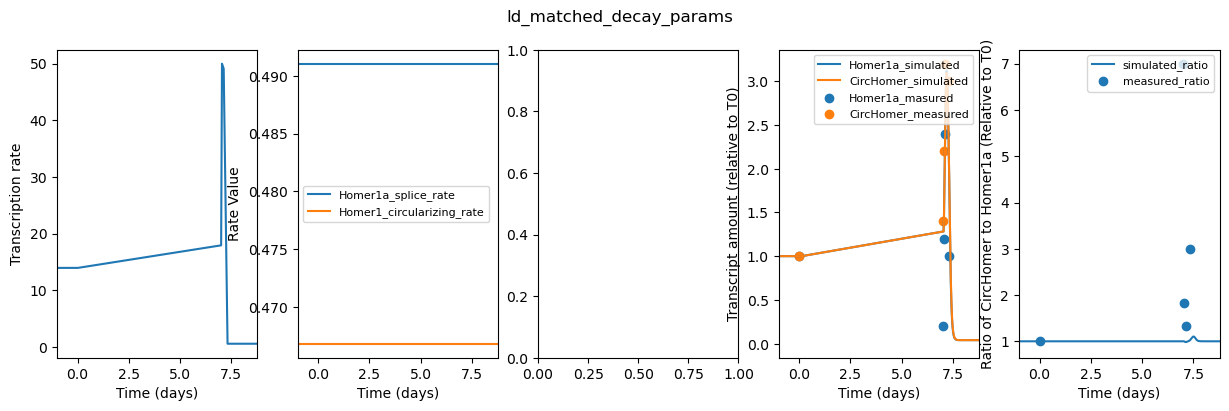

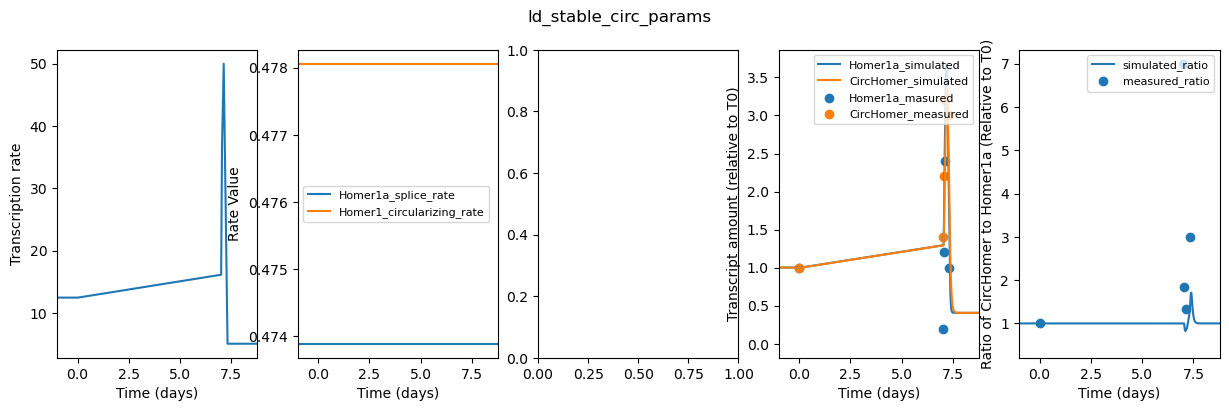

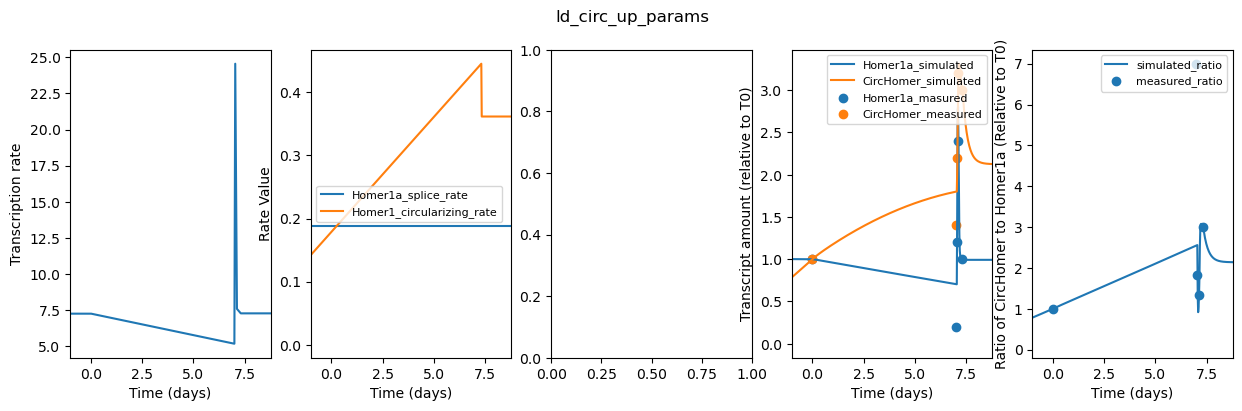

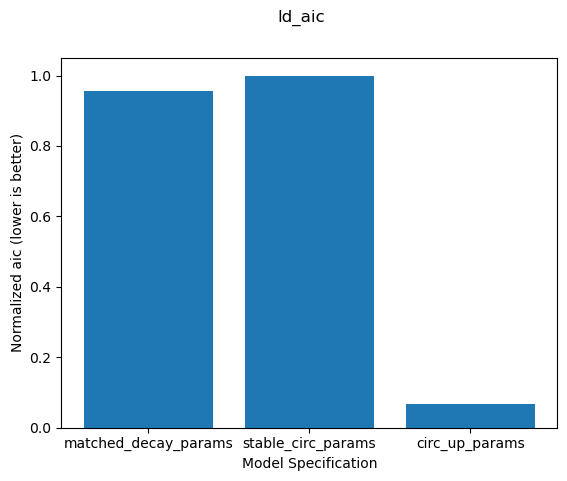

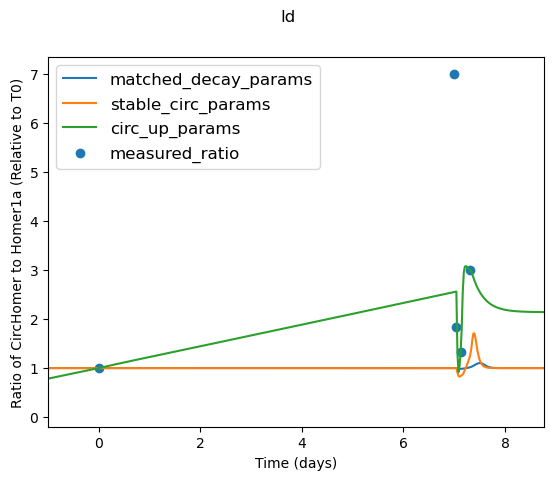

In [11]:
#Repeat with LD
#Produce parameter sets to optimize from starting values with some params fixed or pinned

#steps_per_hour = 8
#min_t_units = -30 #days

#change_day_list_c = [-.1, 0, 7.0]
#circularizing_fraction_list = [.01, .075, .02]


ld_targets_dict = {
    'measured_timepoints': np.array([0,7, 7+1/24, 7+3/24, 7+7.5/24]),  #MUST contain 0
    'measured_circ_homer_levels': np.array([1, 1.4, 2.2, 3.2, 3]),
    'measured_homer1a_levels': np.array([1, .2, 1.2, 2.4, 1]),
}
ld_targets_df = pd.DataFrame(ld_targets_dict)

new_params_dict = OrderedDict()
new_params_dict['transcription_rate']= [.2, .2, 1.2*5, 1.2*2.5, 1.6, .6]
new_params_dict['splice_rate']= [0.5]
new_params_dict['circ_rate']= [.05]
new_params_dict['lin_decay']= [25]
new_params_dict['circ_decay']= [10]   

param_names_list = new_params_dict.keys()

bounds_dict = hf.get_bounds_dict(-cfg.simulate_t_units_before_t0, cfg.get_max_t(ld_targets_df['measured_timepoints']))
        
#establish the null parameters (all there but all 0)
null_ld_params = hf.create_new_homer_parameters(ld_targets_df['measured_timepoints'], param_names_list)

#now override some params from the base null the default params for each of the models we want to test
#and also set bounds on the fitable parameters
stable_circ_params =  hf.update_params(null_ld_params, new_params_dict, bounds_dict)

new_params_dict = {
  'circ_rate': [.01, .075, .02] ,
  'circ_rate_tp': [-.1, 0, 7.0] ,
  }

circ_up_params = hf.update_params(stable_circ_params, new_params_dict, bounds_dict)

new_params_dict = {
  'circ_decay': ['lin_decay_0'],
  }
matched_decay_params = hf.update_params(stable_circ_params, new_params_dict, bounds_dict)
#ld_param_sets['stable_circ_params'].pretty_print()

ld_param_sets = OrderedDict()  #Each new set of parameters will be placed in here
ld_param_sets['matched_decay_params'] = matched_decay_params
ld_param_sets['stable_circ_params'] = stable_circ_params
ld_param_sets['circ_up_params']= circ_up_params

main(ld_param_sets, comp.fit_system, param_names_list, ld_targets_df, experiment_name='ld', repo_path=repo_path)


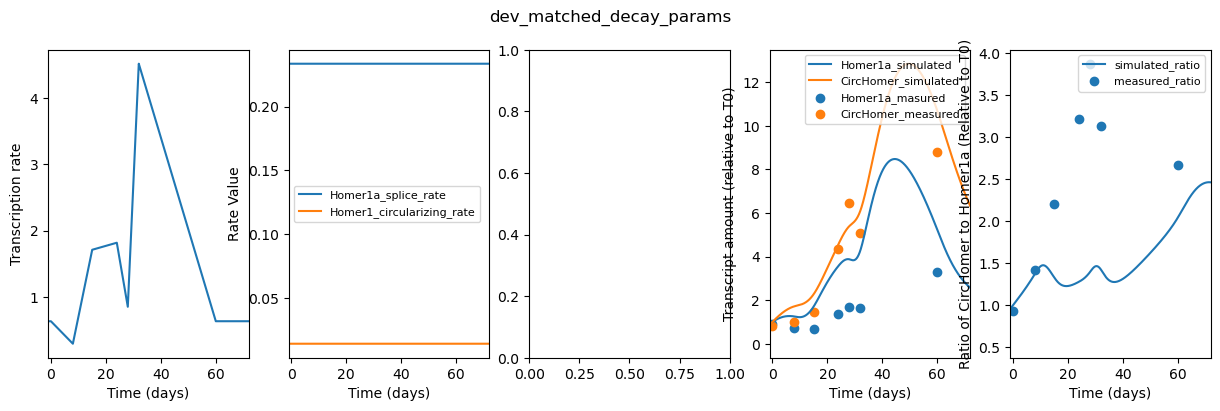

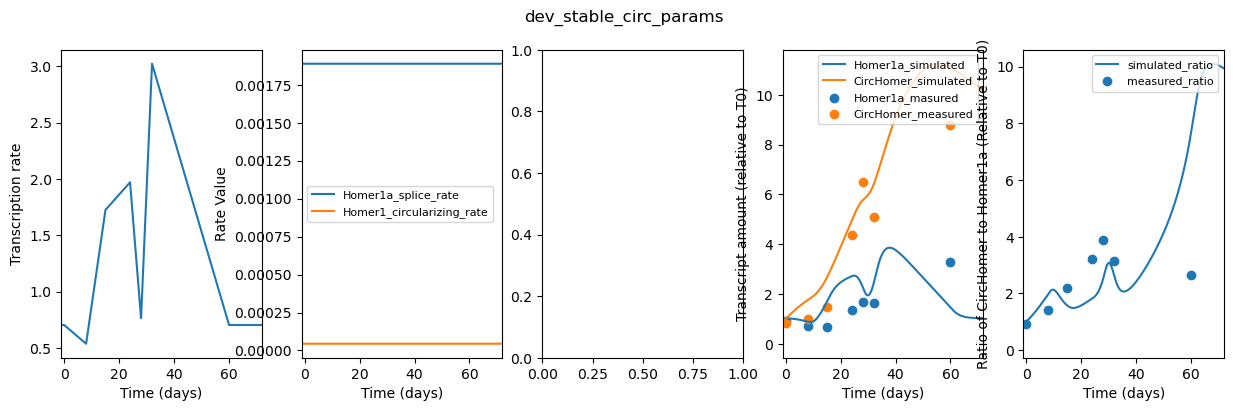

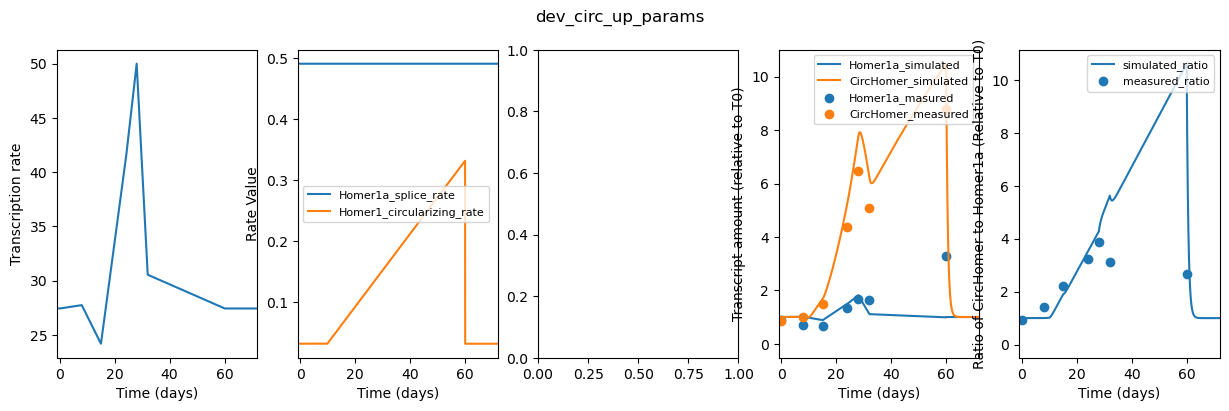

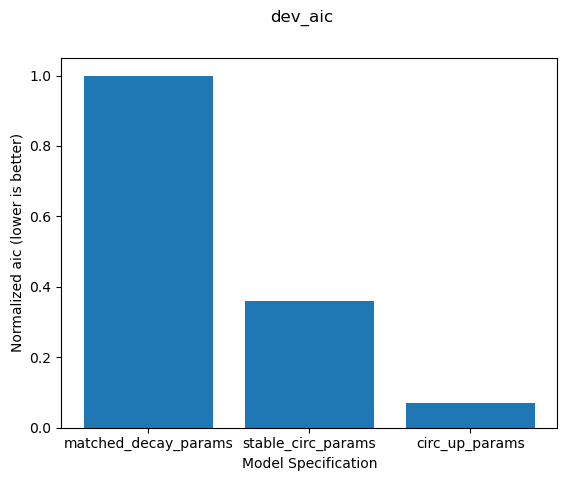

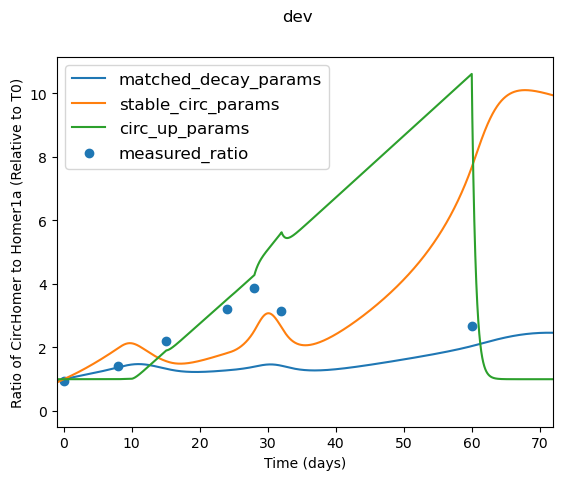

In [12]:
#Repeat with Developement/critical period experiments
#Produce parameter sets to optimize from starting values with some params fixed or pinned

dev_targets_dict = {
    'measured_timepoints': np.array([0,8,15,24,28,32,60]),  #MUST contain 0
    'measured_circ_homer_levels': np.array([.833, 1.012, 1.471, 4.357, 6.483, 5.078, 8.781]),
    'measured_homer1a_levels': np.array([.895, .716, .666, 1.355, 1.674, 1.62, 3.294]),
}
dev_targets_df = pd.DataFrame(dev_targets_dict)

new_params_dict = OrderedDict()
new_params_dict['transcription_rate']=  [.716, .666, 1.355, 1.674, 1.62, 3.294]
new_params_dict['splice_rate']= [0.5]
new_params_dict['circ_rate']= [.01]
new_params_dict['lin_decay']= [10]
new_params_dict['circ_decay']= [.1]   

param_names_list = new_params_dict.keys()

bounds_dict = hf.get_bounds_dict(-cfg.simulate_t_units_before_t0, cfg.get_max_t(dev_targets_df['measured_timepoints']))
        
#establish the null parameters (all there but all 0)
null_dev_params = hf.create_new_homer_parameters(dev_targets_df['measured_timepoints'], param_names_list)

#now override some params from the base null the default params for each of the models we want to test
#and also set bounds on the fitable parameters
stable_circ_params =  hf.update_params(null_dev_params, new_params_dict, bounds_dict)

new_params_dict = {
  'circ_rate':  [.01, .03],
  'circ_rate_tp': [0, 12],
  }

circ_up_params = hf.update_params(stable_circ_params, new_params_dict, bounds_dict)

new_params_dict = {
  'circ_decay': ['lin_decay_0'],
  }
matched_decay_params = hf.update_params(stable_circ_params, new_params_dict, bounds_dict)
#dev_param_sets['stable_circ_params'].pretty_print()

dev_param_sets = OrderedDict()  #Each new set of parameters will be placed in here
dev_param_sets['matched_decay_params'] = matched_decay_params
dev_param_sets['stable_circ_params'] = stable_circ_params
dev_param_sets['circ_up_params']= circ_up_params
main(dev_param_sets, comp.fit_system, param_names_list, dev_targets_df, experiment_name='dev', repo_path=repo_path)


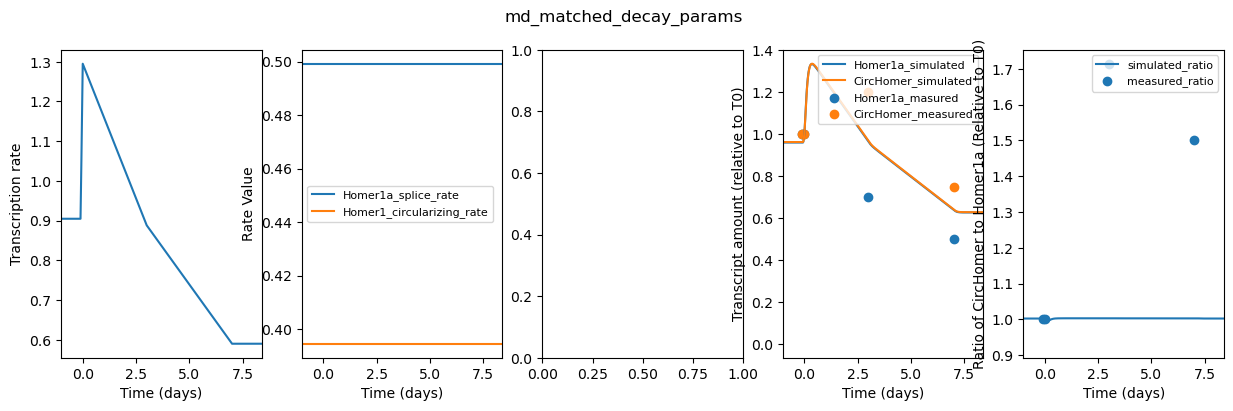

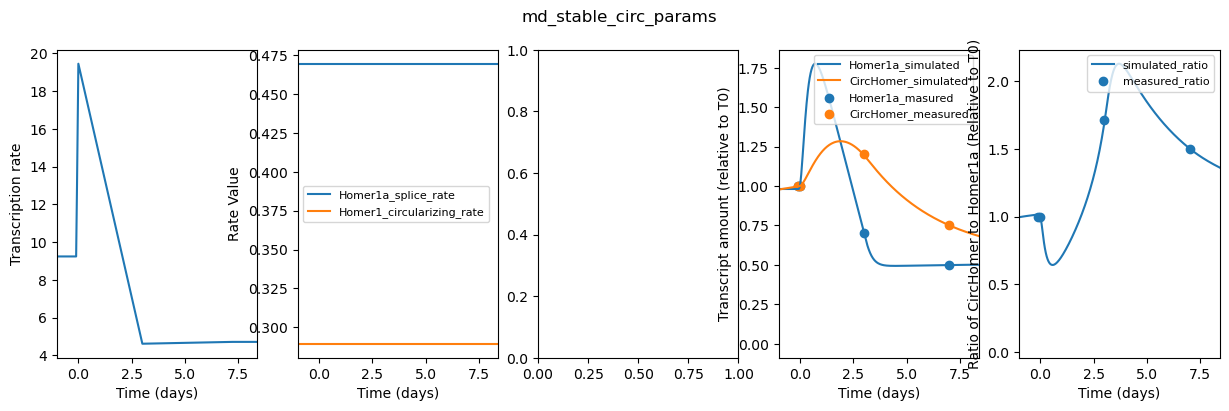

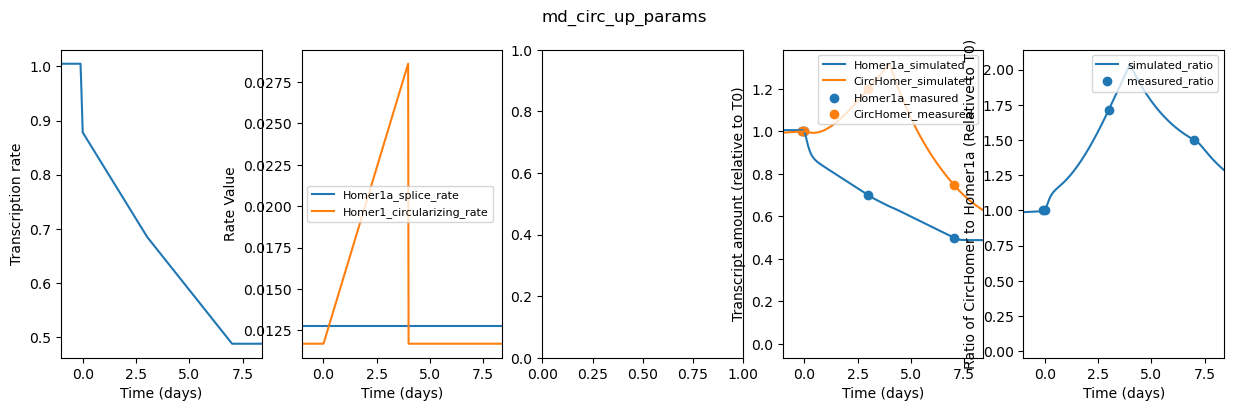

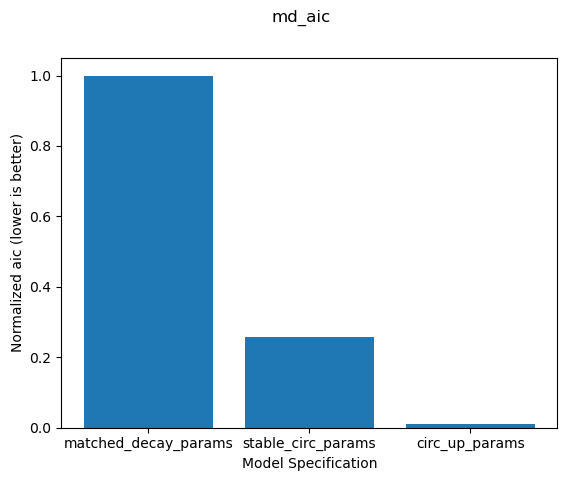

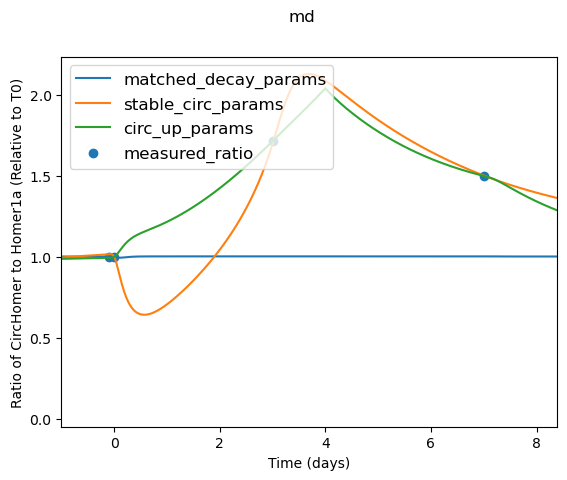

In [13]:
#Repeat with Monocular Deprivation experiments
#Produce parameter sets to optimize from starting values with some params fixed or pinned
md_targets_dict = {
    'measured_timepoints': np.array([-.1, 0, 3,7]),  #MUST contain 0
    'measured_circ_homer_levels': np.array([1, 1, 1.2, .75]),
    'measured_homer1a_levels': np.array([1, 1, .7, .5]),
}
md_targets_df = pd.DataFrame(md_targets_dict)

new_params_dict = OrderedDict()
new_params_dict['transcription_rate']=  [1, 2, 0.7, 0.5]
new_params_dict['splice_rate']= [0.5]
new_params_dict['circ_rate']= [.01]
new_params_dict['lin_decay']= [25]
new_params_dict['circ_decay']= [.2]   

param_names_list = new_params_dict.keys()

bounds_dict = hf.get_bounds_dict(-cfg.simulate_t_units_before_t0, cfg.get_max_t(md_targets_df['measured_timepoints']))
        
#establish the null parameters (all there but all 0)
null_md_params = hf.create_new_homer_parameters(md_targets_df['measured_timepoints'], param_names_list)

#now override some params from the base null the default params for each of the models we want to test
#and also set bounds on the fitable parameters
stable_circ_params =  hf.update_params(null_md_params, new_params_dict, bounds_dict)

new_params_dict = {
  'circ_rate':  [.01, .03],
  'circ_rate_tp': [0, 4],
  }

circ_up_params = hf.update_params(stable_circ_params, new_params_dict, bounds_dict)

new_params_dict = {
  'circ_decay': ['lin_decay_0'],
  }
matched_decay_params = hf.update_params(stable_circ_params, new_params_dict, bounds_dict)
#md_param_sets['stable_circ_params'].pretty_print()

md_param_sets = OrderedDict()  #Each new set of parameters will be placed in here
md_param_sets['matched_decay_params'] = matched_decay_params
md_param_sets['stable_circ_params'] = stable_circ_params
md_param_sets['circ_up_params']= circ_up_params
main(md_param_sets, comp.fit_system, param_names_list, md_targets_df, experiment_name='md', repo_path=repo_path)


In [4]:
num_timesteps = 100
timesteps = np.arange(0,num_timesteps) #in hours?

In [5]:

def simulate_rna_concentrations(production_rate, circularizing_fraction_array, max_t_units = 7, min_t_units=0, params_dict = None, suppress_plots=True):
  #parameters fixed across instantiatnions
  if params_dict is None:
    decay_rate_circ = .2
    decay_rate_linear = 10
    homer1a_fraction = .5
  else:
    decay_rate_circ = params_dict['decay_rate_circ']
    decay_rate_linear = params_dict['decay_rate_linear']
    homer1a_fraction = params_dict['homer1a_fraction']


  num_timesteps = len(production_rate)
  dt = (max_t_units-min_t_units)/num_timesteps
  timesteps = (np.arange(0,num_timesteps)*dt )+ min_t_units
  zero_index = round(-1*min_t_units/dt)

  pre_splice_homer = np.zeros(num_timesteps)
  homer1a = np.zeros(num_timesteps)
  circ_homer = np.zeros(num_timesteps)

  for t in range(num_timesteps-1):
    converted_to_1a = homer1a_fraction*pre_splice_homer[t]*dt
    rest_to_circ = pre_splice_homer[t]*dt*circularizing_fraction_array[t]
    delta_homer = production_rate[t] - decay_rate_linear*dt*pre_splice_homer[t] - converted_to_1a
    homer1a_to_circ = homer1a[t]*dt*circularizing_fraction_array[t]
    delta_homer1a = converted_to_1a - decay_rate_linear*dt*homer1a[t]
    delta_circular = rest_to_circ + homer1a_to_circ - decay_rate_circ*dt*circ_homer[t]

    pre_splice_homer[t+1] = pre_splice_homer[t]+delta_homer
    homer1a[t+1] = homer1a[t]+delta_homer1a
    circ_homer[t+1] = circ_homer[t]+delta_circular

  normalized_linear_amount = homer1a/(homer1a[zero_index])
  normalized_circular_amount = circ_homer/(circ_homer[zero_index])

  if not(suppress_plots):
    plt.plot(timesteps,normalized_linear_amount , label='linear simulated')
    plt.plot(timesteps, normalized_circular_amount, label='circ simulated')
    plt.plot(timesteps, production_rate, label='transcription rate')
    plt.plot(timesteps, circularizing_fraction_array*100, label='circularizing percent')

    plt.xlabel('Day')
    plt.ylabel('Normalized expression level (relative to T=0)')
    plt.legend()
  return timesteps, normalized_linear_amount, normalized_circular_amount


(array([-1.        , -0.97916667, -0.95833333, ..., 69.9375    ,
        69.95833333, 69.97916667]),
 array([0.        , 0.        , 0.04534398, ..., 2.0001111 , 2.00020078,
        2.00028301]),
 array([0.        , 0.        , 0.0052454 , ..., 1.13122815, 1.13157703,
        1.13192459]))

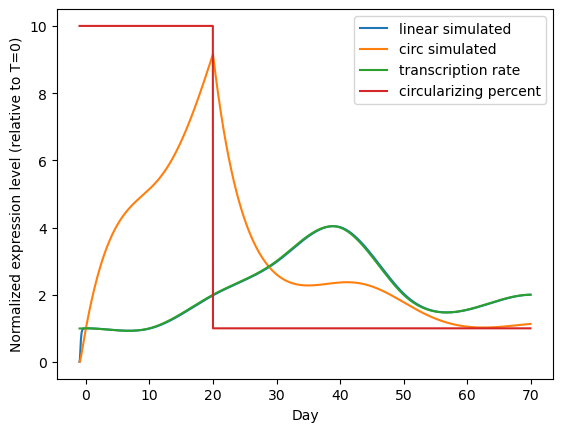

In [6]:
#Test changes here
params_dict = {
  'decay_rate_circ' : .2,
  'decay_rate_linear' : 10,
  'homer1a_fraction' : .5,
  }

change_day_list_t = [10,20,30,40,50,70]
transcription_level_list = [1,2,3,4,2, 2]

change_day_list_c = [10, 20]
circularizing_fraction_list = [.1, .01]

#time length = 60 days
#lets make each timestep 10 minutes
steps_per_hour = 2
max_t_units = 70 #days
min_t_units = -1 #days

def get_timestep_from_day_of_change(day, steps_per_hour, timesteps_before_0):
  return int(day*24*steps_per_hour+timesteps_before_0)

def create_production_rate(transcription_level_list, change_day_list, steps_per_hour,  max_t_units, min_t_units, interpolate=False, add_zero=True):
  #add the zero timepoint at a transciption level of 1 (this level is fixed, not allowed to vary in optimization)
  assert len(transcription_level_list) == len(change_day_list)
  this_transcription_level_list = list(transcription_level_list.copy())
  this_change_day_list = change_day_list.copy()
  if add_zero:
    this_transcription_level_list.insert(0, 1)
    this_change_day_list.insert(0, 0)

  timesteps_before_0 = -1*min_t_units*24*steps_per_hour
  num_timesteps = (max_t_units-min_t_units)*24*steps_per_hour

  step_size = (max_t_units - min_t_units)/num_timesteps
  x = np.arange(min_t_units, max_t_units, step_size)
  if interpolate=='linear':
    production_rate = np.interp(x, this_change_day_list, this_transcription_level_list)
  elif interpolate:
    cs = CubicSpline(this_change_day_list, this_transcription_level_list,
                     bc_type = 'clamped')
    production_rate = cs(x)
  else:
    production_rate = np.ones(num_timesteps)*this_transcription_level_list[0]
    for i, transciption_level in enumerate(this_transcription_level_list):
      change_day = this_change_day_list[i]
      change_timestep = get_timestep_from_day_of_change(change_day, steps_per_hour, timesteps_before_0 )
      production_rate[change_timestep:] = transciption_level
  return production_rate


production_rate = create_production_rate(transcription_level_list, change_day_list_t, steps_per_hour,  max_t_units, min_t_units, interpolate=True)
circularizing_fraction_array = create_production_rate(circularizing_fraction_list, change_day_list_c, steps_per_hour,  max_t_units, min_t_units, interpolate=False, add_zero=False)
#plt.plot(production_rate)
#plt.plot(circularizing_fraction_array)
simulate_rna_concentrations(production_rate, circularizing_fraction_array, max_t_units = max_t_units, min_t_units = min_t_units, suppress_plots = False)

In [12]:



def compare_simulated_to_measured(params_dict, max_t_units, min_t_units,
                                  change_day_list_t, transcription_level_list,
                                  change_day_list_c, circularizing_fraction_list,
                                  day_list, circ_homer_levels,
                                  linear_homer_levels,
                                  suppress_plots=True):
  production_rate = create_production_rate(transcription_level_list, change_day_list_t, steps_per_hour,  max_t_units, min_t_units, interpolate='linear')

  circularizing_fraction_array = create_production_rate(circularizing_fraction_list, change_day_list_c, steps_per_hour,  max_t_units, min_t_units, interpolate=False, add_zero=False)

  #plt.plot(production_rate)
  timesteps, homer1a_cont, circhomer_cont = simulate_rna_concentrations(
      production_rate, circularizing_fraction_array,
      max_t_units = max_t_units, min_t_units = min_t_units,
      params_dict=params_dict, suppress_plots=suppress_plots)
  #print('done simulating')
  #print(f'len circhomer_cont: {len(homer1a_cont)}')
  #print(homer1a_cont)

  norm_circ_homer_levels = circ_homer_levels/circ_homer_levels[0]
  norm_linear_homer_levels = linear_homer_levels/linear_homer_levels[0]
  #I think its already normalized??

  homer1a_predicted = np.interp(day_list, timesteps, homer1a_cont)
  circhomer_predicted = np.interp(day_list, timesteps, circhomer_cont)
  n = len(homer1a_predicted)+len(circhomer_predicted)

  print(f'norm_linear_homer_levels: {norm_linear_homer_levels}')
  print(f'homer1a_predicted: {homer1a_predicted}')
  print(f'circhomer_predicted: {circhomer_predicted}')
  print(f'norm_circ_homer_levels: {norm_circ_homer_levels}')

  squared_error_homer1a = np.sum((homer1a_predicted - norm_linear_homer_levels)**2)
  print(f'squared_error_homer1a: {squared_error_homer1a}')
  squared_error_circ = np.sum((circhomer_predicted - norm_circ_homer_levels)**2)
  print(f'squared_error_circ: {squared_error_circ}')
  rss = (squared_error_homer1a+squared_error_circ)
  print(f'RSS: {rss}')

  k = len(change_day_list_t) + len(params_dict)+len(change_day_list_c)*2
  aic, bic = compute_aic_bic(rss, k, n)

  if not(suppress_plots):
    print(f'aic: {aic}')
    print(f'bic: {bic}')
    plt.scatter(day_list,norm_linear_homer_levels , label='linear measured')
    plt.scatter(day_list, norm_circ_homer_levels, label='circ measured')
    plt.xlabel('Day')
    plt.ylabel('Normalized expression level (relative to T=0)')
    plt.legend()
  return timesteps, homer1a_cont, circhomer_cont, aic

In [13]:
def unpack_parameters(guessed_params, num_circularizing_levels=1):
  params_dict = {}
  this_guessed_params = list(guessed_params).copy()

  params_dict['homer1a_fraction'] = this_guessed_params.pop()
  params_dict['decay_rate_linear'] = this_guessed_params.pop()
  params_dict['decay_rate_circ'] = this_guessed_params.pop()
  circularizing_fraction_list = this_guessed_params[-num_circularizing_levels:]
  change_day_list_c = this_guessed_params[-2*num_circularizing_levels:-num_circularizing_levels]

  this_transcription_level_list = this_guessed_params[:-2*num_circularizing_levels]
  #print(params_dict)
  #print(f'this_transcription_level_list: {this_transcription_level_list}')
  #print(f'circularizing_fraction_list: {circularizing_fraction_list}')
  #print(f'change_day_list_c: {change_day_list_c}')
  #print(f'params_dict: {params_dict}')
  #raise()

  return params_dict, this_transcription_level_list, circularizing_fraction_list, change_day_list_c

def error_func_scalar_homer(
    guessed_params,#<- transciption_level_list with the other parameters appended
    #fixed_params,
    max_t_units, min_t_units, change_day_list_t,
    num_circularizing_levels,
    #targets
    circ_homer_levels, linear_homer_levels, change_relationship = False
    ):

  #print(guessed_params)
  #unpack the guessed_parameters
  params_dict, this_transcription_level_list, circularizing_fraction_list, change_day_list_c  = unpack_parameters(guessed_params, num_circularizing_levels)
  #print(change_day_list)
  #print(f'this_transcription_level_list: {this_transcription_level_list}')
  #print(f'circularizing_fraction_list: {circularizing_fraction_list}')
  #print(f'change_day_list_c: {change_day_list_c}')
  assert len(change_day_list_t) == len(this_transcription_level_list)

  #Apply the function
  production_rate = create_production_rate(this_transcription_level_list, change_day_list_t, steps_per_hour,  max_t_units, min_t_units, interpolate='linear')
  circularizing_fraction_array = create_production_rate(circularizing_fraction_list, change_day_list_c, steps_per_hour,  max_t_units, min_t_units, interpolate=False, add_zero=False)

  timesteps, homer1a_cont, circhomer_cont = simulate_rna_concentrations(
      production_rate, circularizing_fraction_array,
      max_t_units = max_t_units, min_t_units = min_t_units,
      params_dict=params_dict, suppress_plots=True)

  #Now compute the error
  norm_circ_homer_levels = circ_homer_levels/circ_homer_levels[0]
  norm_linear_homer_levels = linear_homer_levels/linear_homer_levels[0]

  homer1a_predicted = np.interp(day_list, timesteps, homer1a_cont)
  circhomer_predicted = np.interp(day_list, timesteps, circhomer_cont)
  n = len(homer1a_predicted)+len(circhomer_predicted)

  squared_error_homer1a = np.sum((homer1a_predicted - norm_linear_homer_levels)**2)
  squared_error_circ = np.sum((circhomer_predicted - norm_circ_homer_levels)**2)
  rss = (squared_error_homer1a+squared_error_circ)
  if np.isnan(rss):
    rss = 100000000000 #just needs to be bigger than error for a reasonable set of parameters
  return rss


In [14]:
def fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               ):

    guessed_params = transcription_level_list.copy()
    bounds = [(0,50) for param in guessed_params]

    guessed_params.extend(change_day_list_c)
    bounds.extend([(min_t_units,max_t_units)]*len(change_day_list_c))

    guessed_params.extend(circularizing_fraction_list)
    bounds.extend([(0,.5)]*len(change_day_list_c))
    num_circularizing_levels = len(circularizing_fraction_list)
    assert len(circularizing_fraction_list) == len(change_day_list_c)

    guessed_params.append(params_dict['decay_rate_circ'])
    bounds.append((0,50))

    guessed_params.append(params_dict['decay_rate_linear'])
    bounds.append((0,50))

    guessed_params.append(params_dict['homer1a_fraction'])
    bounds.append((0,.5))


    print(f'Initial parameter guesses: {guessed_params}')
    rss = error_func_scalar_homer(
        guessed_params,
        max_t_units, min_t_units, change_day_list_t, num_circularizing_levels,
        circ_homer_levels, linear_homer_levels
        )
    print(f'Hand fit RSS: {rss}')


    result = minimize(error_func_scalar_homer, guessed_params,
                      args=(
                            max_t_units,
                            min_t_units,
                            change_day_list_t,
                            num_circularizing_levels,
                            circ_homer_levels,
                            linear_homer_levels
                            ),
                      bounds = bounds,
                      )

    fit_params = result.x
    rss = error_func_scalar_homer(
        fit_params,
        max_t_units, min_t_units, change_day_list_t, num_circularizing_levels,
        circ_homer_levels, linear_homer_levels
        )
    print(f"fit parameter values: {np.array2string(fit_params, precision=2, floatmode='fixed')}")
    print(f'Best fit RSS: {rss}')

    if not(suppress_plots):
        best_params_dict, best_transcription_level_list, best_c_frac_list, best_change_day_list_c = unpack_parameters(fit_params, num_circularizing_levels)
        compare_simulated_to_measured(best_params_dict, max_t_units, min_t_units,
                                          change_day_list_t,best_transcription_level_list,
                                          best_change_day_list_c, best_c_frac_list,
                                          day_list, circ_homer_levels,
                                            linear_homer_levels, suppress_plots = suppress_plots)



norm_linear_homer_levels: [ 1. 12. 19.  3.  2.]
homer1a_predicted: [ 1.          8.13708666 22.82020584  3.05620915  2.        ]
circhomer_predicted: [1.         1.04279232 1.49904447 2.11370155 2.30481519]
norm_circ_homer_levels: [1.  1.5 2.  2.5 3. ]
squared_error_homer1a: 29.519231609914332
squared_error_circ: 1.0925037126585666
RSS: 30.611735322572898
aic: 33.18798349717795
bic: 36.516419520112464
CPU times: total: 62.5 ms
Wall time: 48.9 ms


(-1.0, 3.0)

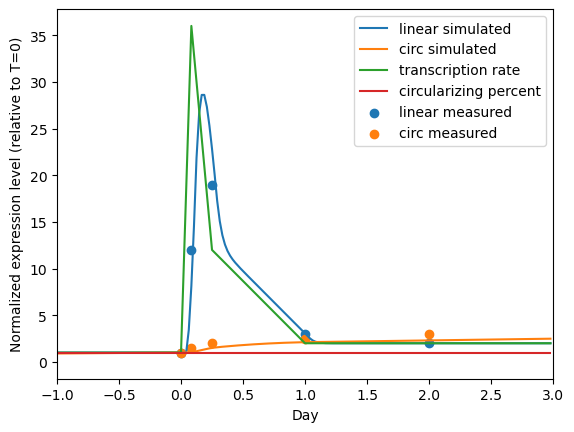

In [15]:
%%time
#Bicuculin experiments
params_dict = {
  'decay_rate_circ': .01 ,
  'decay_rate_linear': 25 ,
  'homer1a_fraction': 0.5 ,
  }

max_t_units = 3 #days
min_t_units = -10 #days

change_day_list_t = [2/24, 6/24, 24/24, 48/24]
transcription_level_list = [12*3, 4*3, 2, 2]

day_list = [0,2/24, 6/24, 24/24, 48/24]
circ_homer_levels = np.array([1, 1.5, 2, 2.5, 3])
linear_homer_levels = np.array([1, 12, 19, 3, 2])

change_day_list_c = [0, 1.5]
circularizing_fraction_list = [.01, .01]

compare_simulated_to_measured(params_dict, max_t_units, min_t_units,
                                  change_day_list_t, transcription_level_list,
                                  change_day_list_c, circularizing_fraction_list,
                                  day_list, circ_homer_levels,
                                    linear_homer_levels, suppress_plots = False)
plt.xlim(-1, 3)


Initial parameter guesses: [36, 12, 2, 2, 0, 0.01, 0.01, 25, 0.5]
Hand fit RSS: 30.611735322572898


C:\Users\Gregg\AppData\Local\Temp\ipykernel_22596\1235964113.py:34: RuntimeWarning: invalid value encountered in divide
  normalized_linear_amount = homer1a/(homer1a[zero_index])


fit parameter values: [3.67e+01 8.83e+00 2.52e+00 2.00e+00 0.00e+00 1.00e-02 1.87e-01 3.28e+01
 1.50e-08]
Best fit RSS: 0.2955271392427297
norm_linear_homer_levels: [ 1. 12. 19.  3.  2.]
homer1a_predicted: [ 1.         12.00283538 19.00120488  3.03512539  2.0303737 ]
circhomer_predicted: [1.         1.09606882 2.01856302 2.70441824 2.70323495]
norm_circ_homer_levels: [1.  1.5 2.  2.5 3. ]
squared_error_homer1a: 0.0021658455131002728
squared_error_circ: 0.29336129372962944
RSS: 0.2955271392427297
aic: -17.215796975782602
bic: -14.492531138836188


(-1.0, 3.0)

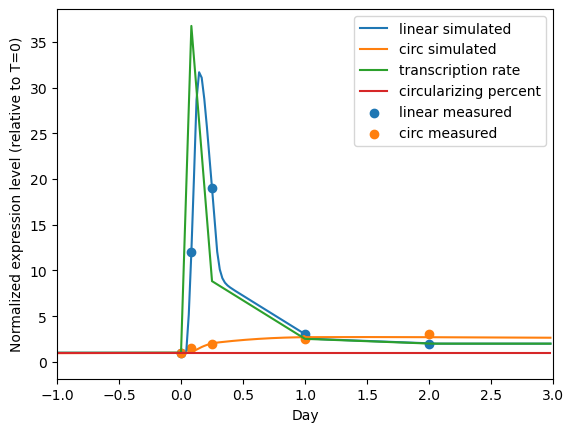

In [16]:
change_day_list_c = [0]
circularizing_fraction_list = [.01]
params_dict = {
  'decay_rate_circ': .01,
  'decay_rate_linear': 25 ,
  'homer1a_fraction': 0.5 ,
  }

fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )
plt.xlim(-1, 3)

Initial parameter guesses: [36, 12, 2, 2, 0, 1.5, 0.01, 0.015, 0.01, 25, 0.5]
Hand fit RSS: 30.541354588703623
fit parameter values: [3.60e+01 1.20e+01 2.00e+00 2.00e+00 0.00e+00 1.50e+00 1.00e-02 1.50e-02
 1.00e-02 2.50e+01 5.00e-01]
Best fit RSS: 30.541354588703623
norm_linear_homer_levels: [ 1. 12. 19.  3.  2.]
homer1a_predicted: [ 1.          8.13708666 22.82020584  3.05620915  2.        ]
circhomer_predicted: [1.         1.04279232 1.49904447 2.11370155 2.35742613]
norm_circ_homer_levels: [1.  1.5 2.  2.5 3. ]
squared_error_homer1a: 29.519231609914332
squared_error_circ: 1.0221229787892914
RSS: 30.541354588703623
aic: 33.16496560387253
bic: 36.493401626807035


C:\Users\Gregg\AppData\Local\Temp\ipykernel_22596\1235964113.py:35: RuntimeWarning: divide by zero encountered in divide
  normalized_circular_amount = circ_homer/(circ_homer[zero_index])
C:\Users\Gregg\AppData\Local\Temp\ipykernel_22596\1235964113.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_circular_amount = circ_homer/(circ_homer[zero_index])


(-1.0, 3.0)

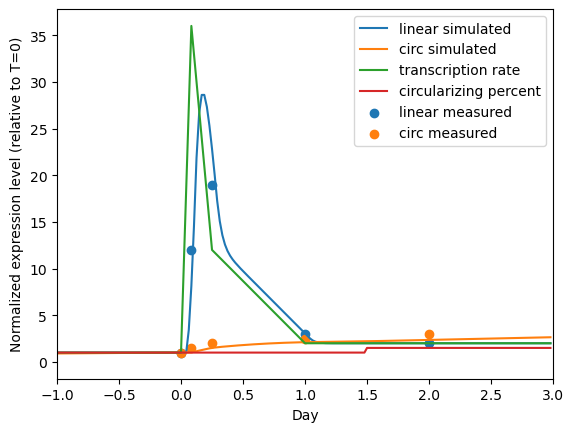

In [17]:
change_day_list_c = [0, 1.5]
circularizing_fraction_list = [.01, .015]

params_dict = {
  'decay_rate_circ': .01 ,
  'decay_rate_linear': 25 ,
  'homer1a_fraction': 0.5 ,
  }

fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )
plt.xlim(-1, 3)

norm_linear_homer_levels: [1.  0.2 1.2 2.4 1. ]
homer1a_predicted: [1.         0.2        1.06713468 2.35744024 1.03679234]
circhomer_predicted: [1.         1.5        1.88075532 3.75895969 2.62362822]
norm_circ_homer_levels: [1.  1.4 2.2 3.2 3. ]
squared_error_homer1a: 0.020818202922154562
squared_error_circ: 0.5660088149371167
RSS: 0.5868270178592713
aic: 1.6438971593767207
bic: 6.182673554287412


(6.5, 8.0)

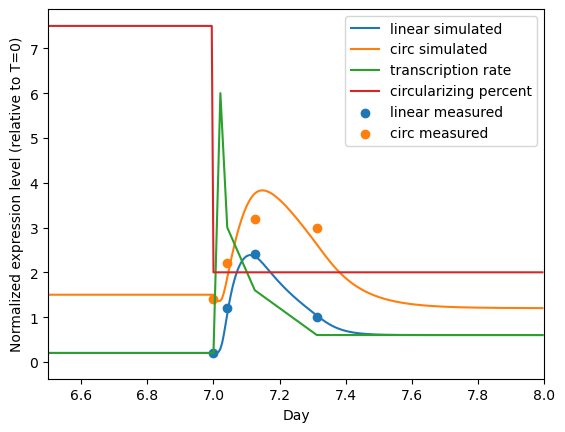

In [18]:
#LD experiments
params_dict = {
  'decay_rate_circ': 10 ,
  'decay_rate_linear': 25 ,
  'homer1a_fraction': 0.5 ,
  }

steps_per_hour = 8
max_t_units = 8 #days
min_t_units = -30 #days

change_day_list_t = [.1, 7, 7+1/48, 7+1/24, 7+3/24, 7+7.5/24]
transcription_level_list = [.2, .2, 1.2*5, 1.2*2.5, 1.6, .6]

day_list = [0,7, 7+1/24, 7+3/24, 7+7.5/24]
circ_homer_levels = np.array([1, 1.4, 2.2, 3.2, 3])
linear_homer_levels = np.array([1, .2, 1.2, 2.4, 1])

change_day_list_c = [-.1, 0, 7.0]
circularizing_fraction_list = [.01, .075, .02]

compare_simulated_to_measured(params_dict, max_t_units, min_t_units,
                                  change_day_list_t, transcription_level_list,
                                  change_day_list_c, circularizing_fraction_list,
                                  day_list, circ_homer_levels,
                                    linear_homer_levels, suppress_plots = False)

plt.xlim(6.5,8)

Initial parameter guesses: [0.2, 0.2, 6.0, 3.0, 1.6, 0.6, 0, 0.01, 10, 25, 0.5]
Hand fit RSS: 9.174040011277214


C:\Users\Gregg\AppData\Local\Temp\ipykernel_22596\1235964113.py:34: RuntimeWarning: invalid value encountered in divide
  normalized_linear_amount = homer1a/(homer1a[zero_index])
C:\Users\Gregg\AppData\Local\Temp\ipykernel_22596\1235964113.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_circular_amount = circ_homer/(circ_homer[zero_index])


fit parameter values: [1.23e+01 0.00e+00 1.49e+01 1.51e+00 1.56e+00 0.00e+00 0.00e+00 8.25e-03
 0.00e+00 1.67e+01 3.19e-08]
Best fit RSS: 1.994255885462362
norm_linear_homer_levels: [1.  0.2 1.2 2.4 1. ]
homer1a_predicted: [1.         0.21367944 1.2024618  2.40468496 1.00341368]
circhomer_predicted: [1.         2.44132116 2.44384149 2.45220462 2.46053477]
norm_circ_homer_levels: [1.  1.4 2.2 3.2 3. ]
squared_error_homer1a: 0.00022678954363228673
squared_error_circ: 1.9940290959187297
RSS: 1.994255885462362
aic: 5.876858980266281
bic: 9.205295003200785


(-1.0, 10.0)

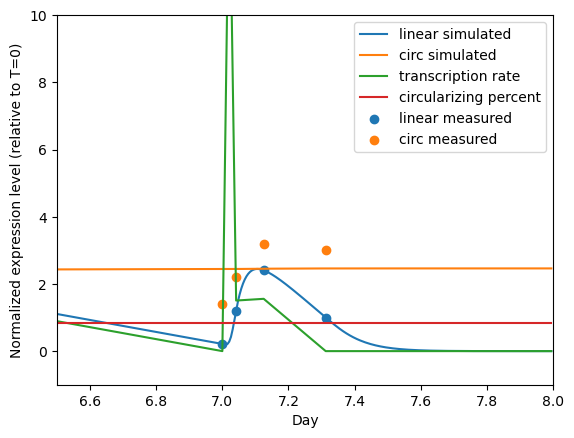

In [19]:
change_day_list_c = [0]
circularizing_fraction_list = [.01]

params_dict = {
  'decay_rate_circ': 10 ,
  'decay_rate_linear': 25 ,
  'homer1a_fraction': 0.5 ,
  }

fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )

plt.xlim(6.5, 8)
plt.ylim(-1,10)

Initial parameter guesses: [0.2, 0.2, 6.0, 3.0, 1.6, 0.6, -0.1, 0, 7.0, 0.01, 0.075, 0.02, 10, 25, 0.5]
Hand fit RSS: 0.5868270178592713


C:\Users\Gregg\AppData\Local\Temp\ipykernel_22596\1235964113.py:34: RuntimeWarning: invalid value encountered in divide
  normalized_linear_amount = homer1a/(homer1a[zero_index])


fit parameter values: [ 8.87e-02  1.98e-01  7.57e+00  1.90e+00  2.53e+00  0.00e+00 -1.00e-01
  0.00e+00  7.00e+00  5.14e-02  4.11e-01  1.01e-01  6.95e+00  2.58e+01
  1.44e-08]
Best fit RSS: 0.11700075507998121
norm_linear_homer_levels: [1.  0.2 1.2 2.4 1. ]
homer1a_predicted: [1.         0.19678414 1.30956154 2.32531135 1.01937388]
circhomer_predicted: [1.         1.55920168 1.94183023 3.283662   2.99393328]
norm_circ_homer_levels: [1.  1.4 2.2 3.2 3. ]
squared_error_homer1a: 0.017967814013298295
squared_error_circ: 0.09903294106668292
RSS: 0.11700075507998121
aic: -14.481599835241987
bic: -9.942823440331296


(-1.0, 12.0)

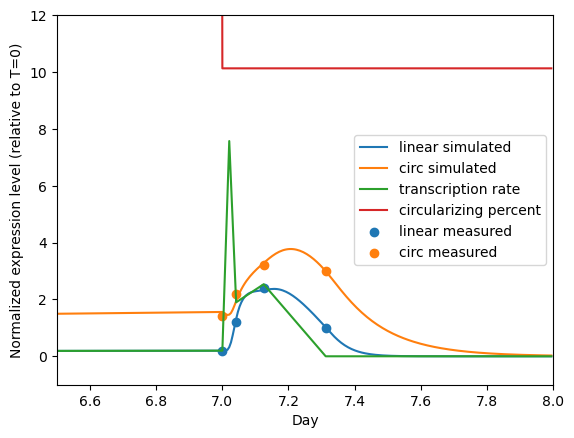

In [20]:
change_day_list_c = [-.1, 0, 7.0]
circularizing_fraction_list = [.01, .075, .02]

#params_dict = {
#  'decay_rate_circ': 10 ,
#  'decay_rate_linear': 25 ,
#  'homer1a_fraction': 0.5 ,
#  }
fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )

plt.xlim(6.5, 8)
plt.ylim(-1, 12)

norm_linear_homer_levels: [1.         0.8        0.74413408 1.51396648 1.87039106 1.81005587
 3.68044693]
homer1a_predicted: [1.         0.72293095 0.66739456 1.34005344 1.65842976 1.62263571
 3.28232755]
circhomer_predicted: [ 1.          1.18784272  1.69996359  3.67418374  4.84892007  5.84098633
 12.89513451]
norm_circ_homer_levels: [ 1.          1.21488595  1.76590636  5.2304922   7.78271309  6.09603842
 10.54141657]
squared_error_homer1a: 0.28062728159594086
squared_error_circ: 16.63935695346966
RSS: 16.919984235065602
aic: 30.652133299601424
bic: 39.59893591421504


(0.0, 65.0)

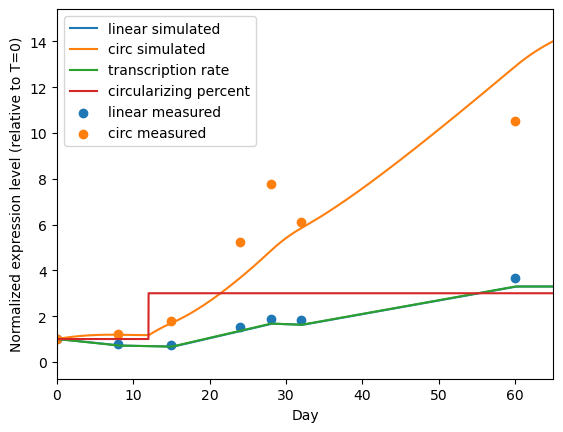

In [21]:
#Developement/critical period experiments
params_dict = {
  'decay_rate_circ' : .1,
  'decay_rate_linear' : 10,
  'homer1a_fraction' : .5,
  'circularizing_fraction' : .01,
  }

steps_per_hour = 2
max_t_units = 70 #days
min_t_units = -10 #days

change_day_list_t = [8,15,24,28,32,60]
transcription_level_list = [.716, .666, 1.355, 1.674, 1.62, 3.294]

day_list = [0,8,15,24,28,32,60]
circ_homer_levels = np.array([.833, 1.012, 1.471, 4.357, 6.483, 5.078, 8.781])
linear_homer_levels = np.array([.895, .716, .666, 1.355, 1.674, 1.62, 3.294])

change_day_list_c = [0, 12]
circularizing_fraction_list = [.01, .03]

compare_simulated_to_measured(params_dict, max_t_units, min_t_units,
                                  change_day_list_t, transcription_level_list,
                                  change_day_list_c, circularizing_fraction_list,
                                  day_list, circ_homer_levels,
                                    linear_homer_levels, suppress_plots = False)


plt.xlim(0, 65)


Initial parameter guesses: [0.716, 0.666, 1.355, 1.674, 1.62, 3.294, 0, 0.01, 0.1, 10, 0.5]
Hand fit RSS: 106.27373772641197
fit parameter values: [1.14e+00 1.97e+00 2.79e+00 2.09e+00 1.14e+00 3.16e+00 0.00e+00 1.00e-02
 6.91e-03 9.98e+00 4.95e-01]
Best fit RSS: 10.004797032420804
norm_linear_homer_levels: [1.         0.8        0.74413408 1.51396648 1.87039106 1.81005587
 3.68044693]
homer1a_predicted: [1.         1.13240392 1.94999266 2.77410192 2.12876709 1.1910222
 3.14803537]
circhomer_predicted: [ 1.          1.81374851  2.83128892  4.82789775  5.71059124  6.23244507
 10.92973489]
norm_circ_homer_levels: [ 1.          1.21488595  1.76590636  5.2304922   7.78271309  6.09603842
 10.54141657]
squared_error_homer1a: 3.8859515389271344
squared_error_circ: 6.1188454934936685
RSS: 10.004797032420804
aic: 17.296102922400692
bic: 24.325733548168536


(0.0, 65.0)

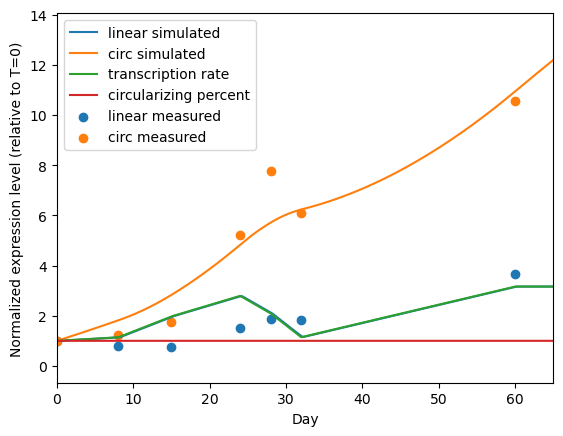

In [22]:
change_day_list_c = [0]
circularizing_fraction_list = [.01]

fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )

plt.xlim(0, 65)


Initial parameter guesses: [0.716, 0.666, 1.355, 1.674, 1.62, 3.294, 0, 20, 0.01, 0.02, 0.1, 10, 0.5]
Hand fit RSS: 42.89617208231064


C:\Users\Gregg\AppData\Local\Temp\ipykernel_22596\1235964113.py:35: RuntimeWarning: divide by zero encountered in divide
  normalized_circular_amount = circ_homer/(circ_homer[zero_index])
C:\Users\Gregg\AppData\Local\Temp\ipykernel_22596\1235964113.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_circular_amount = circ_homer/(circ_homer[zero_index])


fit parameter values: [7.16e-01 6.66e-01 1.35e+00 1.67e+00 1.62e+00 3.29e+00 0.00e+00 2.00e+01
 1.00e-02 2.00e-02 1.00e-01 1.00e+01 5.00e-01]
Best fit RSS: 42.89617208231064
norm_linear_homer_levels: [1.         0.8        0.74413408 1.51396648 1.87039106 1.81005587
 3.68044693]
homer1a_predicted: [1.         0.72293095 0.66739456 1.34005344 1.65842976 1.62263571
 3.28232755]
circhomer_predicted: [1.         1.18784272 1.141386   2.08978187 2.9916173  3.73251377
 8.58696554]
norm_circ_homer_levels: [ 1.          1.21488595  1.76590636  5.2304922   7.78271309  6.09603842
 10.54141657]
squared_error_homer1a: 0.28062728159594086
squared_error_circ: 42.6155448007147
RSS: 42.89617208231064
aic: 41.6761536888182
bic: 49.98389897381656


(0.0, 65.0)

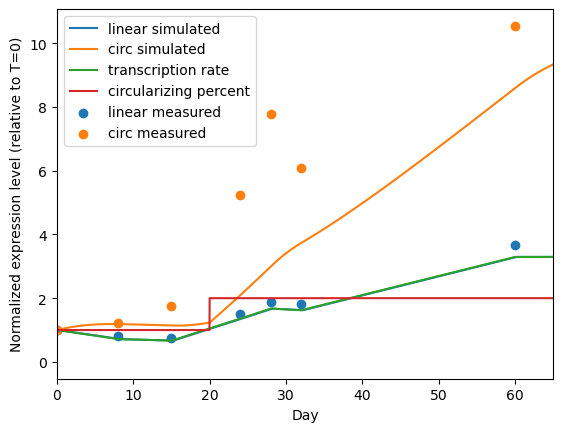

In [23]:
change_day_list_c = [0, 20]
circularizing_fraction_list = [.01, .02]

fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )

plt.xlim(0, 65)

norm_linear_homer_levels: [1.  0.7 0.5]
homer1a_predicted: [1.         0.73551048 0.50396078]
circhomer_predicted: [1.         1.14742448 0.84578272]
norm_circ_homer_levels: [1.   1.2  0.75]
squared_error_homer1a: 0.0012766820060939276
squared_error_circ: 0.011938513916877117
RSS: 0.013215195922971044
aic: -12.70888424677213
bic: -15.207770616035468


(-1.0, 8.0)

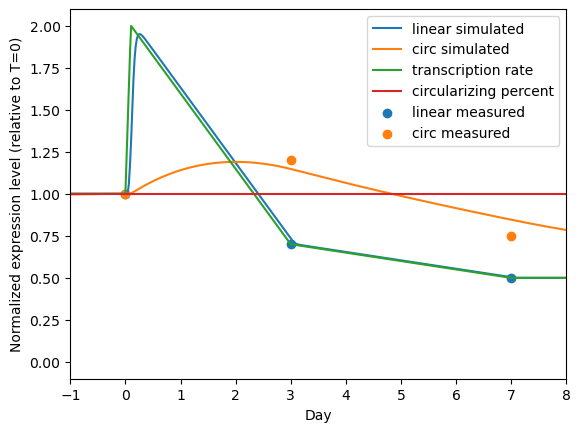

In [24]:
#MD experiments
params_dict = {
  'decay_rate_circ': 0.2 ,
  'decay_rate_linear': 25 ,
  'homer1a_fraction': 0.5 ,
  'circularizing_fraction': .01 ,
  }

max_t_units = 10 #days
min_t_units = -20 #days

change_day_list_t = [0, 0.1, 3,7]
transcription_level_list = [1, 2, 0.7, 0.5]

day_list = [0, 3,7]
circ_homer_levels = np.array([1, 1.2, .75])
linear_homer_levels = np.array([1, .7, .5])
change_day_list_c = [0, 12]
circularizing_fraction_list = [.01, .03]

compare_simulated_to_measured(params_dict, max_t_units, min_t_units,
                                  change_day_list_t, transcription_level_list,
                                  change_day_list_c, circularizing_fraction_list,
                                  day_list, circ_homer_levels,
                                    linear_homer_levels, suppress_plots = False)

plt.xlim(-1, 8)

Initial parameter guesses: [1, 2, 0.7, 0.5, 0, 0.01, 0.2, 25, 0.5]
Hand fit RSS: 0.013215195922971044
fit parameter values: [1.00e+00 2.19e+00 6.58e-01 4.97e-01 0.00e+00 1.00e-02 3.07e-01 2.50e+01
 5.00e-01]
Best fit RSS: 5.100891797022445e-11
norm_linear_homer_levels: [1.  0.7 0.5]
homer1a_predicted: [1.         0.69999819 0.49999871]
circhomer_predicted: [1.         1.19999336 0.74999861]
norm_circ_homer_levels: [1.   1.2  0.75]
squared_error_homer1a: 4.956537912124681e-12
squared_error_circ: 4.6052380058099766e-11
RSS: 5.100891797022445e-11
aic: -134.9446806333457
bic: -136.81884541029322


(-1.0, 8.0)

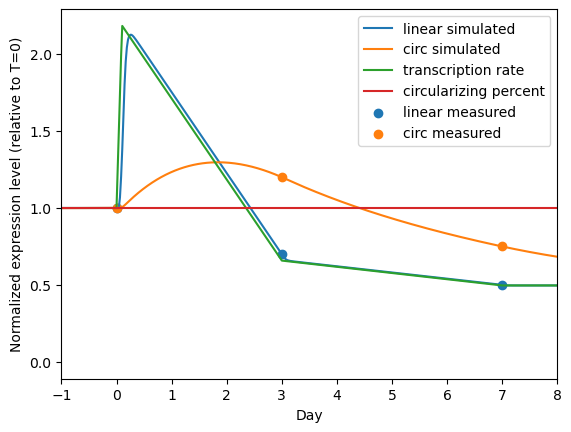

In [25]:
change_day_list_c = [0]
circularizing_fraction_list = [.01]

fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )

plt.xlim(-1, 8)

Initial parameter guesses: [1, 2, 0.7, 0.5, 0, 20, 0.01, 0.02, 0.2, 25, 0.5]
Hand fit RSS: 0.013215195922971044
fit parameter values: [1.00e+00 2.19e+00 6.58e-01 4.97e-01 0.00e+00 1.00e+01 1.00e-02 2.00e-02
 3.07e-01 2.50e+01 5.00e-01]
Best fit RSS: 5.0989062051905665e-11
norm_linear_homer_levels: [1.  0.7 0.5]
homer1a_predicted: [1.         0.69999819 0.4999987 ]
circhomer_predicted: [1.         1.19999336 0.74999861]
norm_circ_homer_levels: [1.   1.2  0.75]
squared_error_homer1a: 4.954629239795716e-12
squared_error_circ: 4.603443281210995e-11
RSS: 5.0989062051905665e-11
aic: -130.94701667002784
bic: -133.23766250851924


(-1.0, 8.0)

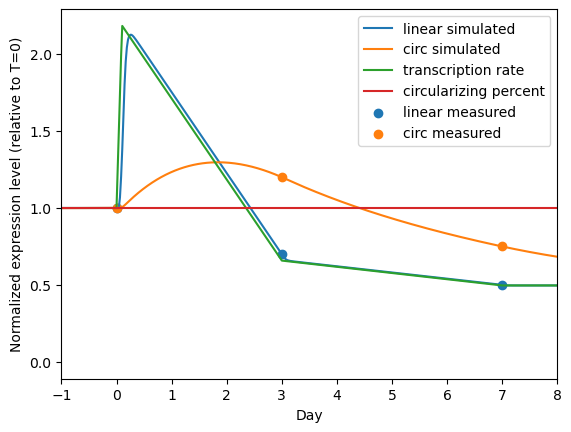

In [26]:
change_day_list_c = [0, 20]
circularizing_fraction_list = [.01, .02]

fit_system(params_dict,
               max_t_units, min_t_units,
               change_day_list_t,
               transcription_level_list,
               change_day_list_c,
               circularizing_fraction_list,
               day_list,
               circ_homer_levels,
               linear_homer_levels,
               suppress_plots = False,
               )

plt.xlim(-1, 8)

Text(0, 0.5, 'Difference between AIC scores')

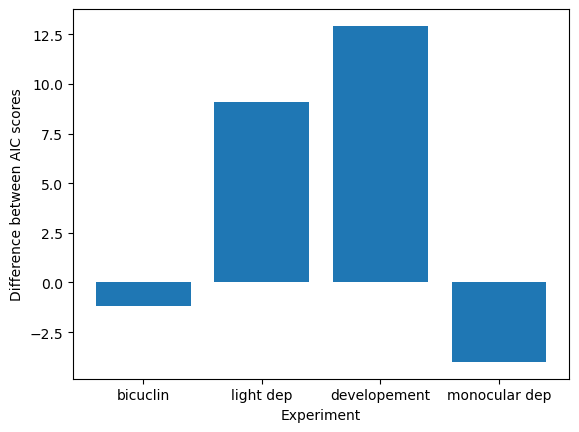

In [27]:
bicuculin_no_pref_aic = -18.17
bicuculin_pref_aic = -17.01
bicuculin_diff = bicuculin_no_pref_aic - bicuculin_pref_aic
ld_no_pref_aic = 6.74
ld_pref_aic = -2.36
ld_diff = ld_no_pref_aic - ld_pref_aic
dev_no_pref_aic = 17.12
dev_pref_aic = 4.20
dev_diff = dev_no_pref_aic - dev_pref_aic
md_no_pref_aic = -136.8
md_pref_aic = -132.8
md_diff = md_no_pref_aic - md_pref_aic

bars = [bicuculin_diff, ld_diff, dev_diff, md_diff]
labels = ['bicuclin', 'light dep', 'developement', 'monocular dep']
plt.bar(labels, bars)
plt.xlabel('Experiment')
plt.ylabel('Difference between AIC scores')

In [ ]:
def func(guessed_params, fixed_params):
  return guessed_params[0]*fixed_params**2+guessed_params[1]*fixed_params+guessed_params[2]

def error_func(guessed_params, fixed_params, targets):
   return func(guessed_params, fixed_params)-targets
   #targets must be larger than guessed params

def error_func_scalar(guessed_params, fixed_params, targets):
  #print(guessed_params)
  rss = sum(abs(func(guessed_params, fixed_params)-targets)**2)
  #print(rss)
  return  rss

   #targets must be larger than guessed params? only for leastsq

x=np.array([1.0,2.5,3.5,4.0,1.1,1.8,2.2,3.7])
y=np.array([6.008,15.722,27.130,33.772,5.257,9.549,11.098,28.828])

initial_guess = (1.0,-1,3.0)

out = leastsq(error_func, initial_guess,args=(x,y))
print(out)
result = minimize(error_func_scalar, initial_guess,args=(x,y))
print(result.x)

(array([ 2.10811816, -1.06889584,  4.40567348]), 1)
[ 2.10811767 -1.06889343  4.40567106]


1440


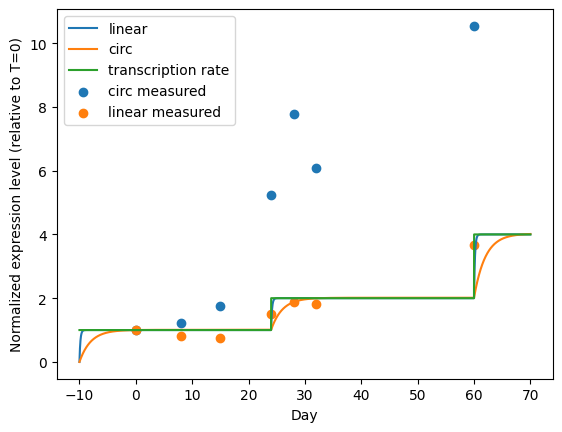

In [ ]:
change_day_list = [24,60]
transcription_level_list = [2,4]
production_rate = create_production_rate(transcription_level_list, change_day_list)

simulate_rna_concentrations(production_rate, decay_rate_circ, decay_rate_linear, max_t_units = max_t_units, min_t_units = min_t_units)

day_list = [0,8,15,24,28,32,60]
circ_homer_levels = np.array([.833, 1.012, 1.471, 4.357, 6.483, 5.078, 8.781])
linear_homer_levels = np.array([.895, .716, .666, 1.355, 1.674, 1.62, 3.294])
norm_circ_homer_levels = circ_homer_levels/circ_homer_levels[0]
norm_linear_homer_levels = linear_homer_levels/linear_homer_levels[0]

plt.scatter(day_list, norm_circ_homer_levels, label='circ measured')
plt.scatter(day_list,norm_linear_homer_levels , label='linear measured')
plt.xlabel('Day')
plt.ylabel('Normalized expression level (relative to T=0)')
plt.legend()


1440


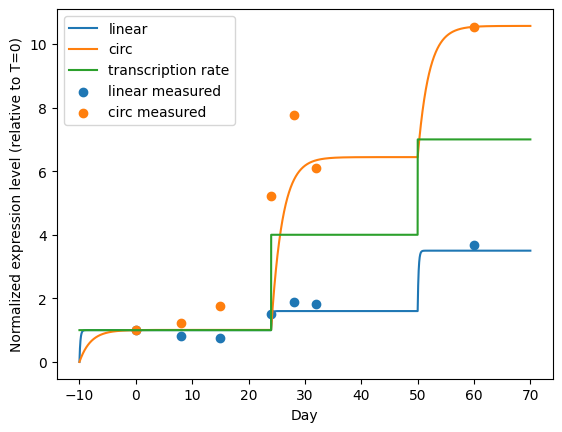

In [ ]:
change_day_list = [24,50]
transcription_level_list = [4,7]
preference_list = [.8, .75]
production_rate = np.ones(num_timesteps)
circ_preference = np.ones(num_timesteps)*.5
for i, transciption_level in enumerate(transcription_level_list):
  change_day = change_day_list[i]
  change_timestep = get_timestep_from_day_of_change(change_day)
  production_rate[change_timestep:] = transciption_level
  circ_preference[change_timestep:] = preference_list[i]
simulate_rna_concentrations(production_rate, decay_rate_circ, decay_rate_linear, max_t_units = max_t_units, min_t_units = min_t_units, circ_preference = circ_preference)

day_list = [0,8,15,24,28,32,60]
circ_homer_levels = np.array([.833, 1.012, 1.471, 4.357, 6.483, 5.078, 8.781])
linear_homer_levels = np.array([.895, .716, .666, 1.355, 1.674, 1.62, 3.294])
nrom_circ_homer_levels = circ_homer_levels/circ_homer_levels[0]
norm_linear_homer_levels = linear_homer_levels/linear_homer_levels[0]

plt.scatter(day_list,norm_linear_homer_levels , label='linear measured')
plt.scatter(day_list, nrom_circ_homer_levels, label='circ measured')
plt.xlabel('Day')
plt.ylabel('Normalized expression level (relative to T=0)')
plt.legend()

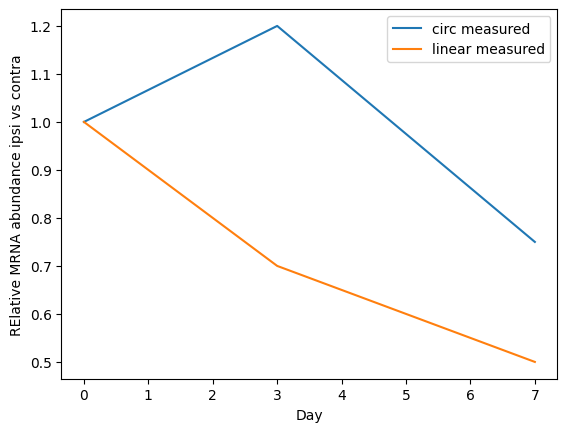

In [ ]:
day_list = [0, 3,7]
circ_homer_levels = np.array([1, 1.2, .75])
linear_homer_levels = np.array([1, .7, .5])

plt.plot(day_list, circ_homer_levels, label='circ measured')
plt.plot(day_list,linear_homer_levels , label='linear measured')
plt.xlabel('Day')
plt.ylabel('RElative MRNA abundance ipsi vs contra')
plt.legend()

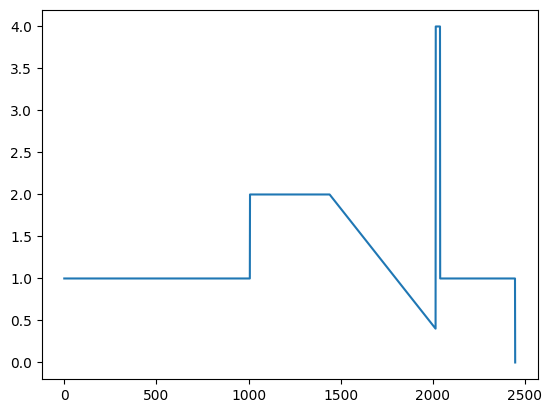

In [ ]:

#Recreate fig 2c
#time length = 60 days
#lets make each timestep 10 minutes
steps_per_hour = 6
max_t_units = 10 #days
min_t_units = -7
timesteps_before_0 = -1*min_t_units*24*steps_per_hour
num_timesteps = (max_t_units-min_t_units)*24*steps_per_hour

#Plasticity event at t=0. lets say it lasts for 3 days
first_change = 0*24*steps_per_hour+timesteps_before_0
second_change = 3*24*steps_per_hour+timesteps_before_0

#then reintruduce the light at day 7
third_change = 7*24*steps_per_hour+timesteps_before_0
#the rate increases for 2 hours
fourth_change = (7*24+1)*steps_per_hour+timesteps_before_0
fifth_change = (7*24+4)*steps_per_hour+timesteps_before_0

production_rate = np.zeros(num_timesteps)
production_rate[0:first_change] = 1
production_rate[first_change:-1] = 2
production_rate[second_change:-1] = -.4*np.arange(0,len(production_rate[second_change:-1]))/24/steps_per_hour+2 #lets say linear decay for the second half of the light deprivation
#y = mx+b - b is 2, m is -.9
production_rate[third_change:-1] = 4
production_rate[fourth_change:-1] = 4
production_rate[fifth_change:-1] = 1

plt.plot(production_rate)


1008


(array([0.        , 0.04166667, 0.08159722, ..., 1.00000006, 1.00000005,
        1.00000005]),
 array([0.        , 0.00357966, 0.0071469 , ..., 1.10568333, 1.10542381,
        1.1051652 ]))

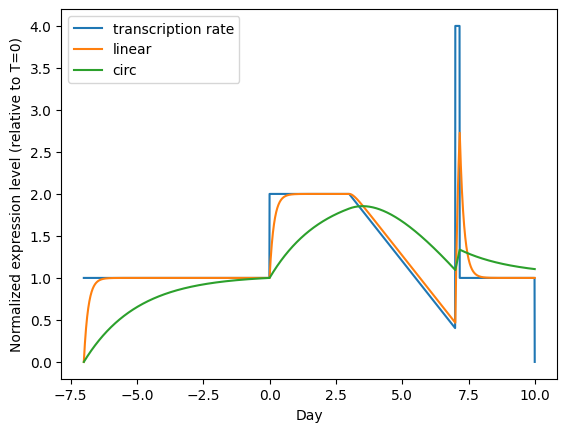

In [ ]:
simulate_rna_concentrations(production_rate, decay_rate_circ, decay_rate_linear, max_t_units = max_t_units, min_t_units = min_t_units)

In [ ]:
#dictated by the experimental timeline
right_eye_input #(0 to 1)
left_eye_input  #(0 to 1)

#fixed by the developement of the comissure
fraction_right_eye_input #(0 to 1)
fraction_left_eye_input #(0 to 1)
#^^ this actually doesn't seem fair... depends on whether you are in monocular or binocular

#determined by the model
fraction_right_eye_spines #(0 to 1%)
fraction_left_eye_spines  #(0 to 1%)

#compute activity to get the delta
right_eye_activation = right_eye_input*fraction_right_eye_input*fraction_right_eye_spines
left_eye_activation = left_eye_input*fraction_left_eye_input*fraction_left_eye_spines

binocular_activation = right_eye_activation+left_eye_activation


cortical_response = nonlinear_func(binocular_activation)
contra_response = nonlinear_func(right_eye_activation)
ipsi_response = nonlinear_func(left_eye_activation)


#calcium is proportional to cortical response
goal_cortical_binocular_response = 1

#this should do some integratino over many past timepoints
shift_activity = (goal_cortical_binocular_response - cortical_response)/goal_cortical_binocular_response
#^ Negative if too high, positive if too low.



#The change in spine fractions
loss = #function of protiens
gain = #function of protiens
gain_left = gain*left_eye_activation
gain_right = gain*right_eye_activation

delta_fraction_right = loss+gain_right
delta_fraction_left = loss+gain_left




Notes:
Need to consider that homer 1a might be able to be converted to circ homer
how do we deal with the whole cortex? BCM would cause the ipsi inputs to just keep getting weaker ... oh wait! The activity is the same, there are just fewer of them. So I have something wrong here.

so maybe simulate 100 possible synapses with a strength on each? different parts of cortex have diffrent availability - 50-50, 70-30, 100-0

homer1a is spine deconstruction
circ homer carries it around and helps with deconstruction
but what dictates spine gain? I guess BDNF? no, BDNF also seems to be for reshuffling
probably the other homers, Glua1 PSD95 and the like cause synapse formaiton. Produce more of those and the cell will start forming more or stronger synapses


In [ ]:
%%time
#fitting for bicuculin

decay_rates = np.logspace(-2, 1.6, 10) #.001 up to 50           #eventually do 50 instead of 10
fractions = np.linspace(0,1,11)  #0 to 1 intervals of .5        #eventually do 21 instead of 11
transcription_levels = np.round(np.logspace(-2, 1.6, 3), decimals=2)                 #eventually do 50 instead of 10 or 3
change_day_list = np.linspace(0,.3,4)                           #eventually do out to .8 with 9 instead of .4 with 3
starting_transciption_rate = 1

#just doing it the hacky for loop way first
#eventually may want to numpify and run them in tandem, but those vectors will get large
max_t_units = 3 #days
min_t_units = -10 #days

day_list = [0,2/24, 6/24, 24/24, 48/24]
circ_homer_levels = np.array([1, 1.5, 2, 2.5, 3])
linear_homer_levels = np.array([1, 12, 19, 3, 2])

#need to generate the different transcription curves to loop through
total_curves = len(transcription_levels)**(len(change_day_list)-1)
print(total_curves)
min_aic = 40
best_h1a_cont = None
best_circ_cont = None
best_params = None
best_curve = None

for curve_num in range(total_curves):
  transcription_level_list = [starting_transciption_rate]
  remainder = curve_num
  for i in range(len(change_day_list)-1):
    transcription_level_list.append(transcription_levels[int(remainder % len(transcription_levels))])
    remainder = remainder//len(change_day_list)

  #print(transcription_level_list)
  #generate the params_dict
  for decay_rate_circ in decay_rates:
    for decay_rate_linear in decay_rates:
      for homer1a_fraction in fractions:
        for circularizing_fraction in fractions:
          params_dict = {
            'decay_rate_circ': decay_rate_circ,
            'decay_rate_linear': decay_rate_linear ,
            'homer1a_fraction': homer1a_fraction ,
            'circularizing_fraction': circularizing_fraction ,
            }
          timesteps, homer1a_cont, circhomer_cont, aic = compare_simulated_to_measured(
                                  params_dict, max_t_units, min_t_units,
                                  change_day_list, transcription_level_list,
                                  day_list, circ_homer_levels,
                                    linear_homer_levels)
          if aic<min_aic:
            min_aic = aic
            best_h1a_cont = homer1a_cont
            best_circ_cont = circhomer_cont
            best_params = params_dict
            best_curve = transcription_level_list

print(min_aic)
print(best_h1a_cont)
print(best_circ_cont)
print(best_params)
print(best_curve)